<a href="https://colab.research.google.com/github/honeyd3wy/Sentiment-Classifier-with-KoELECTRA/blob/main/Sentiment_Classifier_with_KoELECTRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Steam 리뷰 데이터 감정분석 with koELECTRA

## 1. 데이터셋 준비하기

In [1]:
!pip3 install torch==1.9.0+cu102 torchvision==0.10.0+cu102 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 831.4 MB 2.4 kB/s 
     |████████████████████████████████| 22.1 MB 1.2 MB/s 
     |████████████████████████████████| 1.9 MB 8.0 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu111
    Uninstalling torch-1.9.0+cu111:
      Successfully uninstalled torch-1.9.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu111
    Uninstalling torchvision-0.10.0+cu111:
      Successfully uninstalled torchvision-0.10.0+cu111


In [2]:
# Hugging Face의 트랜스포머 설치
!pip install transformers

     |████████████████████████████████| 3.1 MB 7.2 MB/s 
     |████████████████████████████████| 59 kB 7.4 MB/s 
     |████████████████████████████████| 895 kB 53.6 MB/s 
     |████████████████████████████████| 596 kB 77.4 MB/s 
     |████████████████████████████████| 3.3 MB 53.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import tensorflow as tf
import torch

from transformers import AutoTokenizer
from transformers import ElectraForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from torch.nn import functional as F
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np
import random
import time
import datetime

In [4]:
!wget https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt

--2021-11-09 07:19:30--  https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11631607 (11M) [text/plain]
Saving to: ‘steam.txt’

steam.txt           100%[===================>]  11.09M  --.-KB/s    in 0.06s   

2021-11-09 07:19:31 (180 MB/s) - ‘steam.txt’ saved [11631607/11631607]



In [5]:
data = pd.read_csv('steam.txt', sep='\t', header=None)
data.columns = ['label', 'review']
data.head()

,label,review
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요


In [6]:
data.shape

(100000, 2)

In [7]:
# 결측값 확인
data.isna().sum()

label     0
review    0
dtype: int64

In [8]:
# 중복 확인
data.duplicated().sum() # 1
# 중복 제거
data.drop_duplicates(['review'], keep='first', inplace=True)
data.shape

(99892, 2)

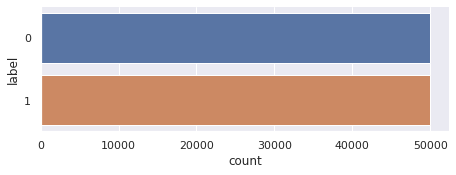

In [9]:
# class 분포 파악
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme()
sns.catplot(y='label', data = data, kind='count', height=2.6, aspect=2.5, orient='h');

## 2. 토큰화

In [10]:
tokenizer = AutoTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

Downloading:   0%|          | 0.00/61.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/467 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/257k [00:00<?, ?B/s]

In [11]:
tokenizer.vocab_size

35000

In [12]:
class SentimentReviewDataset(Dataset):
  
  def __init__(self, dataset):
    self.dataset = dataset
    self.tokenizer = AutoTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self, idx):
    row = self.dataset.iloc[idx, 0:2].values
    text = row[1]
    y = row[0]

    inputs = self.tokenizer(
        text, 
        return_tensors='pt',
        truncation=True,
        max_length=256,
        pad_to_max_length=True,
        add_special_tokens=True
        )
    
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]

    return input_ids, attention_mask, y

In [13]:
# 데이터 나누기
train_data, test_data = train_test_split(data, test_size=0.2)

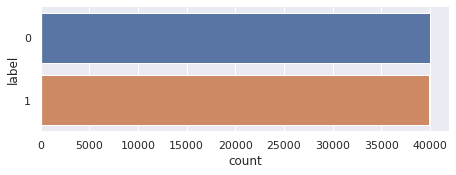

In [14]:
# chance level 설정을 위한 class 분포 확인
sns.catplot(y='label', data = train_data, kind='count', height=2.6, aspect=2.5, orient='h');

- chance level = 0.5

In [15]:
train_dataset = SentimentReviewDataset(train_data)
test_dataset = SentimentReviewDataset(test_data)

In [16]:
train_dataset[0]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


(tensor([    2,  3467,  4152,  4279,  7483,  7504,  4070,  3123,  4025,  4129,
          3508,  4007,  4294,  2735, 21115,  4172, 10749,  8748,  4219, 11870,
         18781,  7505,  7504,  4070,  3123,  4025,  4129,  6848,  2174,  4311,
             3,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

## 3. 모델 만들기

In [26]:
# GPU 사용
device = torch.device("cuda")

In [27]:
model = ElectraForSequenceClassification.from_pretrained("monologg/koelectra-base-v3-discriminator").to(device)

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: 

In [ ]:
model

## 4. training(fine-tuining)

In [34]:
epochs = 3
batch_size = 32
optimizer = AdamW(model.parameters(), lr=1e-5)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [35]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [36]:
losses = []
accuracies = []

for i in range(epochs):
  total_loss = 0.0
  correct = 0
  total = 0
  batches = 0

  model.train()

  for input_ids_batch, attention_masks_batch, y_batch in tqdm(train_loader):
    optimizer.zero_grad()
    y_batch = y_batch.to(device)
    y_pred = model(input_ids_batch.to(device), attention_mask=attention_masks_batch.to(device))[0]
    loss = F.cross_entropy(y_pred, y_batch)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    _, predicted = torch.max(y_pred, 1)
    correct += (predicted == y_batch).sum()
    total += len(y_batch)

    batches += 1
    if batches % 100 == 0:
      print("Batch Loss:", total_loss, "Accuracy:", correct.float() / total)
  
  losses.append(total_loss)
  accuracies.append(correct.float() / total)
  print("Train Loss:", total_loss, "Accuracy:", correct.float() / total)

  0%|          | 0/2498 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Batch Loss: 66.53938621282578 Accuracy: tensor(0.5984, device='cuda:0')
Batch Loss: 116.90815192461014 Accuracy: tensor(0.6845, device='cuda:0')
Batch Loss: 162.46720299124718 Accuracy: tensor(0.7221, device='cuda:0')
Batch Loss: 204.82891602814198 Accuracy: tensor(0.7442, device='cuda:0')
Batch Loss: 247.38921469449997 Accuracy: tensor(0.7568, device='cuda:0')
Batch Loss: 288.58036153018475 Accuracy: tensor(0.7665, device='cuda:0')
Batch Loss: 329.8361944705248 Accuracy: tensor(0.7730, device='cuda:0')
Batch Loss: 370.82794420421124 Accuracy: tensor(0.7770, device='cuda:0')
Batch Loss: 410.41941599547863 Accuracy: tensor(0.7814, device='cuda:0')
Batch Loss: 450.5305504053831 Accuracy: tensor(0.7857, device='cuda:0')
Batch Loss: 489.76640129089355 Accuracy: tensor(0.7889, device='cuda:0')
Batch Loss: 527.9404503703117 Accuracy: tensor(0.7920, device='cuda:0')
Batch Loss: 565.9347387999296 Accuracy: tensor(0.7954, device='cuda:0')
Batch Loss: 605.1029424369335 Accuracy: tensor(0.7980, d

  0%|          | 0/2498 [00:00<?, ?it/s]

Batch Loss: 32.1422728151083 Accuracy: tensor(0.8597, device='cuda:0')
Batch Loss: 65.12049534916878 Accuracy: tensor(0.8603, device='cuda:0')
Batch Loss: 99.55884312093258 Accuracy: tensor(0.8572, device='cuda:0')
Batch Loss: 132.68360064923763 Accuracy: tensor(0.8561, device='cuda:0')
Batch Loss: 165.70702244341373 Accuracy: tensor(0.8549, device='cuda:0')
Batch Loss: 200.2634672448039 Accuracy: tensor(0.8547, device='cuda:0')
Batch Loss: 233.05220343917608 Accuracy: tensor(0.8553, device='cuda:0')
Batch Loss: 266.2600435987115 Accuracy: tensor(0.8555, device='cuda:0')
Batch Loss: 301.0117676332593 Accuracy: tensor(0.8547, device='cuda:0')
Batch Loss: 336.14561887830496 Accuracy: tensor(0.8534, device='cuda:0')
Batch Loss: 369.85976407676935 Accuracy: tensor(0.8529, device='cuda:0')
Batch Loss: 403.99986653774977 Accuracy: tensor(0.8531, device='cuda:0')
Batch Loss: 435.68059649318457 Accuracy: tensor(0.8538, device='cuda:0')
Batch Loss: 469.193467438221 Accuracy: tensor(0.8541, devi

  0%|          | 0/2498 [00:00<?, ?it/s]

Batch Loss: 29.063962385058403 Accuracy: tensor(0.8778, device='cuda:0')
Batch Loss: 58.76126214116812 Accuracy: tensor(0.8780, device='cuda:0')
Batch Loss: 86.46252623200417 Accuracy: tensor(0.8814, device='cuda:0')
Batch Loss: 115.29838140308857 Accuracy: tensor(0.8817, device='cuda:0')
Batch Loss: 143.31348030269146 Accuracy: tensor(0.8826, device='cuda:0')
Batch Loss: 170.40928538888693 Accuracy: tensor(0.8828, device='cuda:0')
Batch Loss: 198.76535371690989 Accuracy: tensor(0.8830, device='cuda:0')
Batch Loss: 226.77430061995983 Accuracy: tensor(0.8824, device='cuda:0')
Batch Loss: 254.2118031270802 Accuracy: tensor(0.8831, device='cuda:0')
Batch Loss: 281.6920744739473 Accuracy: tensor(0.8837, device='cuda:0')
Batch Loss: 312.0691674016416 Accuracy: tensor(0.8823, device='cuda:0')
Batch Loss: 340.3672700114548 Accuracy: tensor(0.8823, device='cuda:0')
Batch Loss: 370.30762300267816 Accuracy: tensor(0.8814, device='cuda:0')
Batch Loss: 398.4259621836245 Accuracy: tensor(0.8816, de

In [37]:
# 모델 저장하기
torch.save(model.state_dict(), "model.pt")

In [38]:
losses, accuracies

([1027.9731665551662, 833.1789309680462, 709.2388709895313],
 [tensor(0.8102, device='cuda:0'),
  tensor(0.8550, device='cuda:0'),
  tensor(0.8816, device='cuda:0')])

## 5. Evaluation

In [39]:
model.load_state_dict(torch.load("model.pt"))

<All keys matched successfully>

In [40]:
model.eval()

test_correct = 0
test_total = 0

for input_ids_batch, attention_masks_batch, y_batch in tqdm(test_loader):
  y_batch = y_batch.to(device)
  y_pred = model(input_ids_batch.to(device), attention_mask=attention_masks_batch.to(device))[0]
  _, predicted = torch.max(y_pred, 1)
  test_correct += (predicted == y_batch).sum()
  test_total += len(y_batch)

print("Accuracy:", test_correct.float() / test_total)

  0%|          | 0/1249 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Accuracy: tensor(0.8402, device='cuda:0')


## 6. 추가 학습 + 성능 확인

In [41]:
# epochs = 3
# batch_size = 32
# optimizer = AdamW(model.parameters(), lr=1e-5)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

losses = []
accuracies = []

for i in range(epochs):
  total_loss = 0.0
  correct = 0
  total = 0
  batches = 0

  model.train()

  for input_ids_batch, attention_masks_batch, y_batch in tqdm(train_loader): # tqdm : 진행률 프로세스바
    optimizer.zero_grad()
    y_batch = y_batch.to(device)
    y_pred = model(input_ids_batch.to(device), attention_mask=attention_masks_batch.to(device))[0]
    loss = F.cross_entropy(y_pred, y_batch)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    _, predicted = torch.max(y_pred, 1)
    correct += (predicted == y_batch).sum()
    total += len(y_batch)

    batches += 1
    if batches % 100 == 0:
      print("Batch Loss:", total_loss, "Accuracy:", correct.float() / total)
  
  losses.append(total_loss)
  accuracies.append(correct.float() / total)
  print("Train Loss:", total_loss, "Accuracy:", correct.float() / total)

  0%|          | 0/2498 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Batch Loss: 23.619969487190247 Accuracy: tensor(0.9053, device='cuda:0')
Batch Loss: 47.85490760207176 Accuracy: tensor(0.9028, device='cuda:0')
Batch Loss: 70.77632402256131 Accuracy: tensor(0.9043, device='cuda:0')
Batch Loss: 93.95098549500108 Accuracy: tensor(0.9069, device='cuda:0')
Batch Loss: 118.41222760826349 Accuracy: tensor(0.9064, device='cuda:0')
Batch Loss: 140.63265985250473 Accuracy: tensor(0.9070, device='cuda:0')
Batch Loss: 165.0565017387271 Accuracy: tensor(0.9070, device='cuda:0')
Batch Loss: 187.08779203891754 Accuracy: tensor(0.9077, device='cuda:0')
Batch Loss: 210.84612201154232 Accuracy: tensor(0.9073, device='cuda:0')
Batch Loss: 235.78755450248718 Accuracy: tensor(0.9065, device='cuda:0')
Batch Loss: 260.0225768350065 Accuracy: tensor(0.9062, device='cuda:0')
Batch Loss: 282.47251154109836 Accuracy: tensor(0.9067, device='cuda:0')
Batch Loss: 307.49877785518765 Accuracy: tensor(0.9061, device='cuda:0')
Batch Loss: 331.5745907537639 Accuracy: tensor(0.9055, d

  0%|          | 0/2498 [00:00<?, ?it/s]

Batch Loss: 19.089255169034004 Accuracy: tensor(0.9262, device='cuda:0')
Batch Loss: 39.24914549663663 Accuracy: tensor(0.9234, device='cuda:0')
Batch Loss: 60.93385726958513 Accuracy: tensor(0.9221, device='cuda:0')
Batch Loss: 79.01651607081294 Accuracy: tensor(0.9242, device='cuda:0')
Batch Loss: 98.26607666909695 Accuracy: tensor(0.9246, device='cuda:0')
Batch Loss: 116.1712459847331 Accuracy: tensor(0.9261, device='cuda:0')
Batch Loss: 134.7930710222572 Accuracy: tensor(0.9256, device='cuda:0')
Batch Loss: 155.23429698310792 Accuracy: tensor(0.9251, device='cuda:0')
Batch Loss: 174.33132068999112 Accuracy: tensor(0.9251, device='cuda:0')
Batch Loss: 195.23134456016123 Accuracy: tensor(0.9241, device='cuda:0')
Batch Loss: 214.75085217691958 Accuracy: tensor(0.9237, device='cuda:0')
Batch Loss: 235.0444082263857 Accuracy: tensor(0.9234, device='cuda:0')
Batch Loss: 254.60804685764015 Accuracy: tensor(0.9234, device='cuda:0')
Batch Loss: 273.73555642925203 Accuracy: tensor(0.9236, de

  0%|          | 0/2498 [00:00<?, ?it/s]

Batch Loss: 15.871881112456322 Accuracy: tensor(0.9425, device='cuda:0')
Batch Loss: 31.563595730811357 Accuracy: tensor(0.9400, device='cuda:0')
Batch Loss: 44.785755379125476 Accuracy: tensor(0.9425, device='cuda:0')
Batch Loss: 59.339722737669945 Accuracy: tensor(0.9430, device='cuda:0')
Batch Loss: 75.6683369455859 Accuracy: tensor(0.9422, device='cuda:0')
Batch Loss: 91.17852028738707 Accuracy: tensor(0.9417, device='cuda:0')
Batch Loss: 106.47148728463799 Accuracy: tensor(0.9416, device='cuda:0')
Batch Loss: 121.02404971141368 Accuracy: tensor(0.9420, device='cuda:0')
Batch Loss: 137.0589468134567 Accuracy: tensor(0.9417, device='cuda:0')
Batch Loss: 153.47053396236151 Accuracy: tensor(0.9416, device='cuda:0')
Batch Loss: 169.3525142716244 Accuracy: tensor(0.9418, device='cuda:0')
Batch Loss: 182.60426191054285 Accuracy: tensor(0.9425, device='cuda:0')
Batch Loss: 198.2547219954431 Accuracy: tensor(0.9425, device='cuda:0')
Batch Loss: 214.44925498217344 Accuracy: tensor(0.9422, d

In [43]:
torch.save(model.state_dict(), "model2.pt")

In [44]:
losses, accuracies

([596.6823905110359, 485.7744143418968, 393.5618826113641],
 [tensor(0.9035, device='cuda:0'),
  tensor(0.9241, device='cuda:0'),
  tensor(0.9402, device='cuda:0')])

- 모델 불러오기 및 성능 평가

In [69]:
model2 = ElectraForSequenceClassification.from_pretrained("monologg/koelectra-base-v3-discriminator").to(device)

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: 

In [70]:
model2.load_state_dict(torch.load("model2.pt"))

<All keys matched successfully>

In [71]:
model2.eval()

test_correct = 0
test_total = 0

for input_ids_batch, attention_masks_batch, y_batch in tqdm(test_loader):
  y_batch = y_batch.to(device)
  y_pred = model2(input_ids_batch.to(device), attention_mask=attention_masks_batch.to(device))[0]
  _, predicted = torch.max(y_pred, 1)
  test_correct += (predicted == y_batch).sum()
  test_total += len(y_batch)

print("Accuracy:", test_correct.float() / test_total)

  0%|          | 0/1249 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Accuracy: tensor(0.8375, device='cuda:0')


## 7. 성능 비교(Classification Report)

In [74]:
from transformers import AutoModelForSequenceClassification, pipeline
model1 = AutoModelForSequenceClassification.from_pretrained("monologg/koelectra-base-v3-discriminator")
model1.load_state_dict(torch.load('model.pt', map_location=torch.device('cpu')))
sentiment_classifier_1 = pipeline('sentiment-analysis', tokenizer=tokenizer, model=model1)


model2 = AutoModelForSequenceClassification.from_pretrained("monologg/koelectra-base-v3-discriminator")
model2.load_state_dict(torch.load('model2.pt', map_location=torch.device('cpu')))
sentiment_classifier_2 = pipeline('sentiment-analysis', tokenizer=tokenizer, model=model2)

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: 

In [76]:
y_pred = []
total_len = len(test_data)
for cnt, review in enumerate(test_data['review']):
    pred = sentiment_classifier_1(review)
    # print(f"{cnt} / {total_len} : {pred[0]}")
    if pred[0]['label'] == 'LABEL_1':
        y_pred.append(1)
    else:
        y_pred.append(0)

In [77]:
y_pred2 = []
total_len = len(test_data)
for cnt, review in enumerate(test_data['review']):
    pred2 = sentiment_classifier_2(review)
    if pred2[0]['label'] == 'LABEL_1':
        y_pred2.append(1)
    else:
        y_pred2.append(0)

In [78]:
from sklearn.metrics import classification_report
print(classification_report(test_data['label'], y_pred))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85      9953
           1       0.88      0.79      0.83     10026

    accuracy                           0.84     19979
   macro avg       0.84      0.84      0.84     19979
weighted avg       0.84      0.84      0.84     19979



In [79]:
print(classification_report(test_data['label'], y_pred2))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84      9953
           1       0.86      0.81      0.83     10026

    accuracy                           0.84     19979
   macro avg       0.84      0.84      0.84     19979
weighted avg       0.84      0.84      0.84     19979



## 8. Base Line 모델 : Keras 기본 Embedding vector로 분류하기

In [80]:
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer

In [82]:
X_train = train_data['review']
y_train = train_data['label']
X_test = test_data['review']
y_test = test_data['label']

In [83]:
# 1. keras 의 tokenizer 에 텍스트를 학습

tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(X_train)

In [90]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

207608


In [84]:
# 2. pad_sequence로 패딩 처리
X_train_encoded = tokenizer.texts_to_sequences(X_train)

max_len = max(len(sent) for sent in X_train_encoded)
print(max_len)

27


In [85]:
print(f'Mean length of train set: {np.mean([len(sent) for sent in X_train], dtype=int)}')

Mean length of train set: 46


In [87]:
maxlen = 50

X_train=pad_sequences(X_train_encoded, maxlen=maxlen, padding='post')
y_train=np.array(y_train)

In [88]:
X_train.shape

(79913, 50)

In [91]:
dim = 50

base_model = tf.keras.models.Sequential()

base_model.add(tf.keras.layers.Embedding(vocab_size, dim, input_length=max_len))
base_model.add(GlobalAveragePooling1D())
base_model.add(Dense(1, activation='sigmoid'))

base_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
base_model.fit(X_train, y_train, batch_size=64, epochs=6, validation_split=0.2)

Epoch 1/6
999/999 [==============================] - 7s 5ms/step - loss: 0.6597 - acc: 0.6359 - val_loss: 0.6110 - val_acc: 0.6936
Epoch 2/6
999/999 [==============================] - 5s 5ms/step - loss: 0.5761 - acc: 0.6992 - val_loss: 0.5700 - val_acc: 0.6967
Epoch 3/6
999/999 [==============================] - 5s 5ms/step - loss: 0.5501 - acc: 0.7077 - val_loss: 0.5592 - val_acc: 0.6956
Epoch 4/6
999/999 [==============================] - 4s 5ms/step - loss: 0.5427 - acc: 0.7100 - val_loss: 0.5577 - val_acc: 0.7022
Epoch 5/6
999/999 [==============================] - 4s 4ms/step - loss: 0.5400 - acc: 0.7105 - val_loss: 0.5573 - val_acc: 0.6983
Epoch 6/6
999/999 [==============================] - 5s 5ms/step - loss: 0.5390 - acc: 0.7101 - val_loss: 0.5648 - val_acc: 0.6944


In [92]:
X_test_encoded = tokenizer.texts_to_sequences(X_test)

X_test=pad_sequences(X_test_encoded, maxlen=maxlen, padding='post')
y_test=np.array(y_test)

In [93]:
base_model.evaluate(X_test, y_test)

625/625 [==============================] - 1s 1ms/step - loss: 0.5472 - acc: 0.7051


[0.547202467918396, 0.705090343952179]